In [38]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler , OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
customer_df = pd.read_csv('/Users/cillian/Desktop/Ironhack/Ironhack-unit-4/lab-cleaning-categorical-data/files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv')
customer_df

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,Urban,Married,73,18,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,Suburban,Single,85,9,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,Suburban,Married,96,34,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [3]:
customer_df.columns = customer_df.columns.str.lower().str.replace(" ","_")
customer_df = customer_df.rename(columns={ 'customer': 'customer_id','employmentstatus' : 'employment_status'})
customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date'])

In [4]:
customer_df = customer_df.set_index('customer_id')
# Setting the index to customer_id to keep the info in the dataframe even though not usefull for a ML model.

#### Loading the continuous and discrete variables in different df variables.

In [5]:
numerical_df = customer_df.select_dtypes(include= 'number')
categorical_df = customer_df.select_dtypes('object')

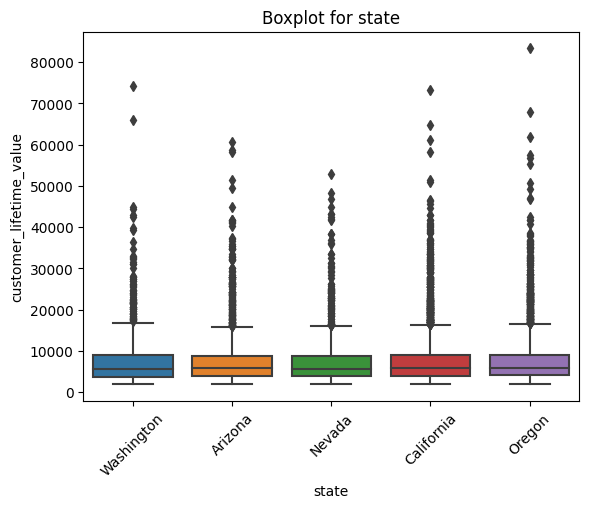

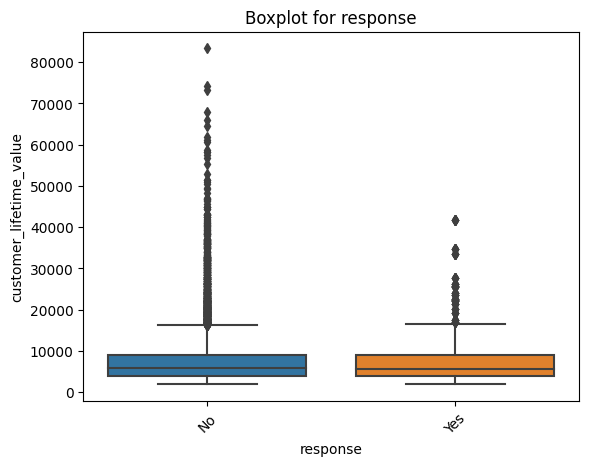

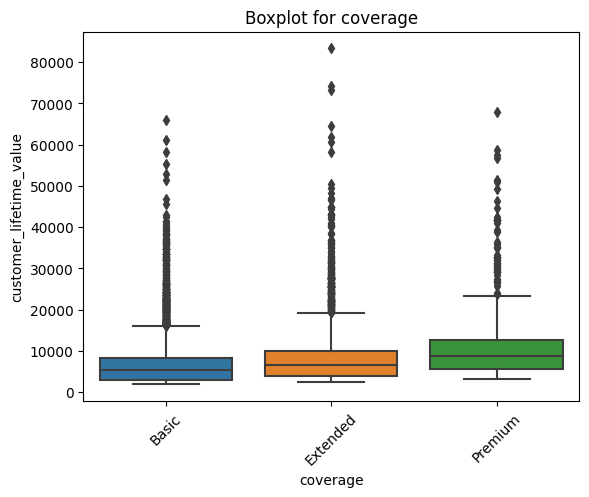

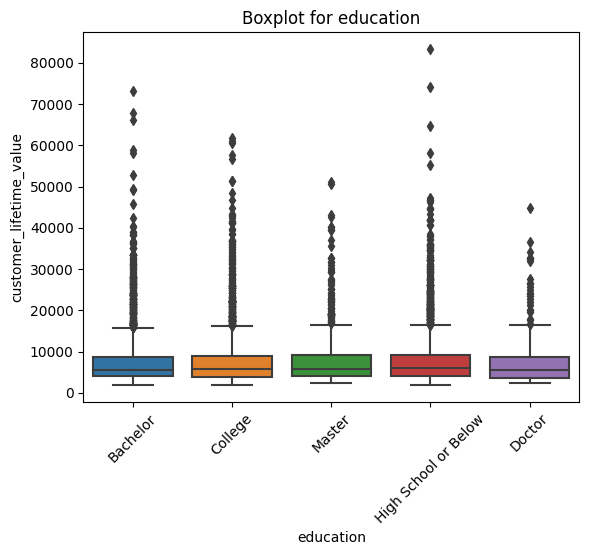

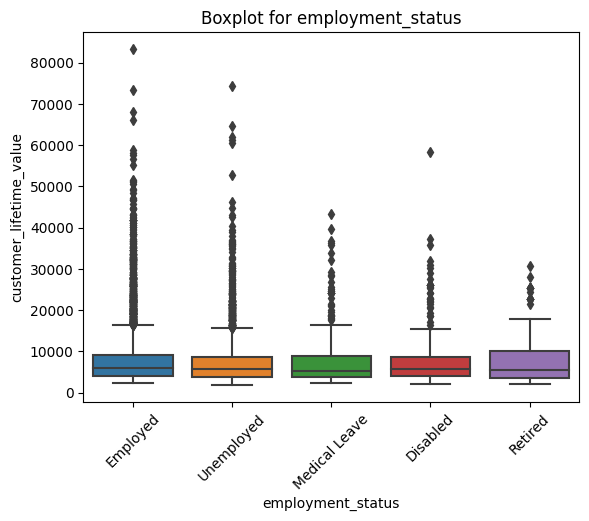

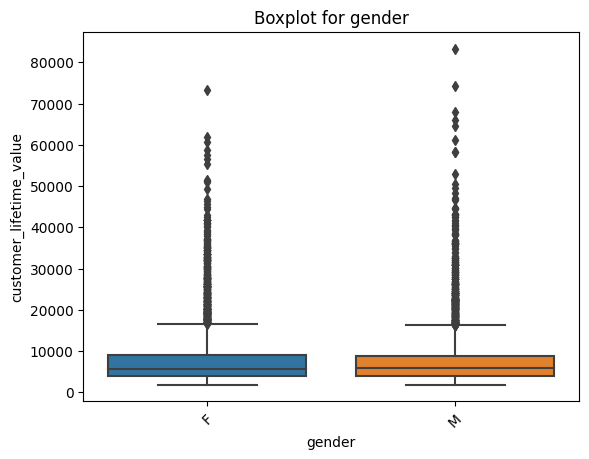

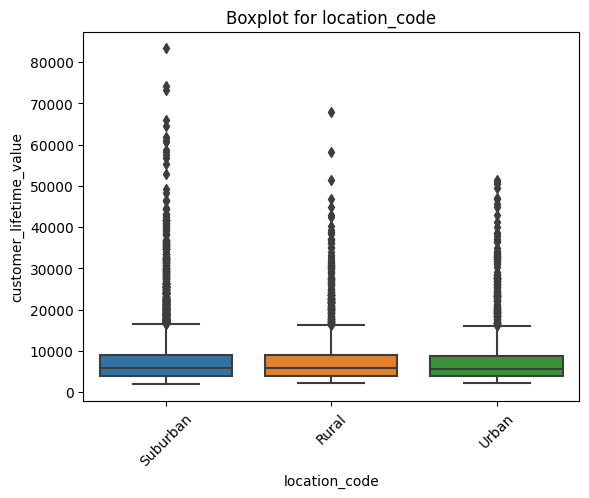

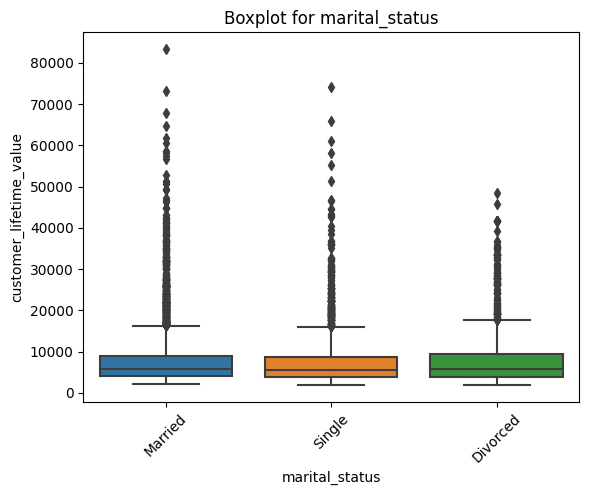

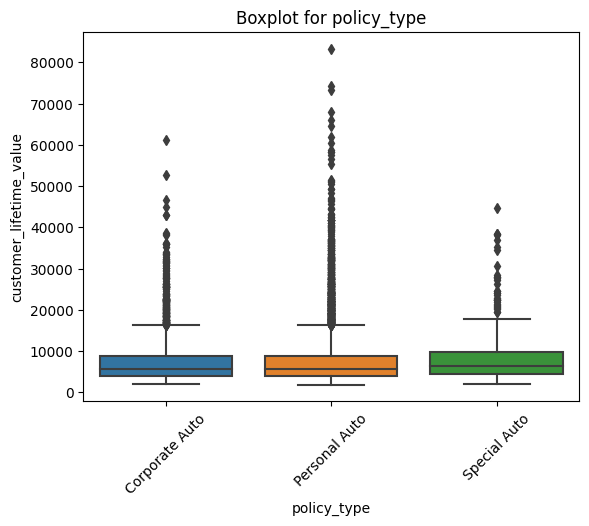

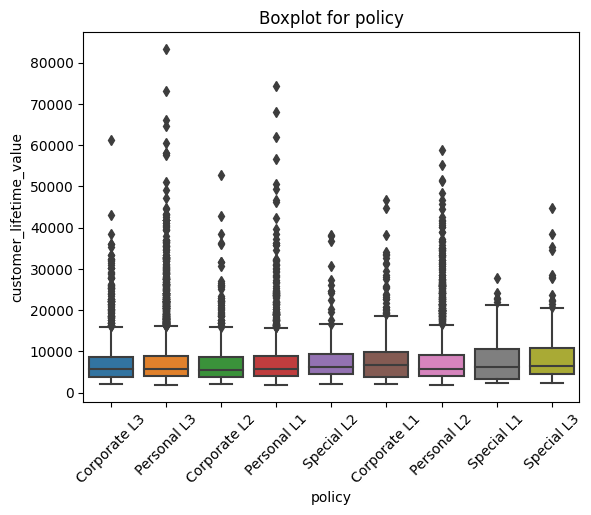

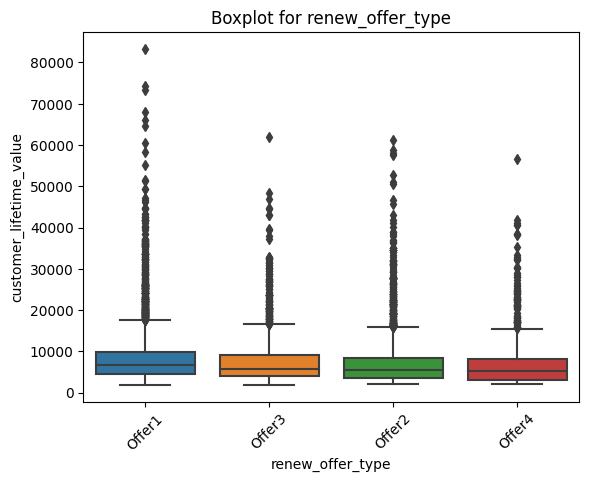

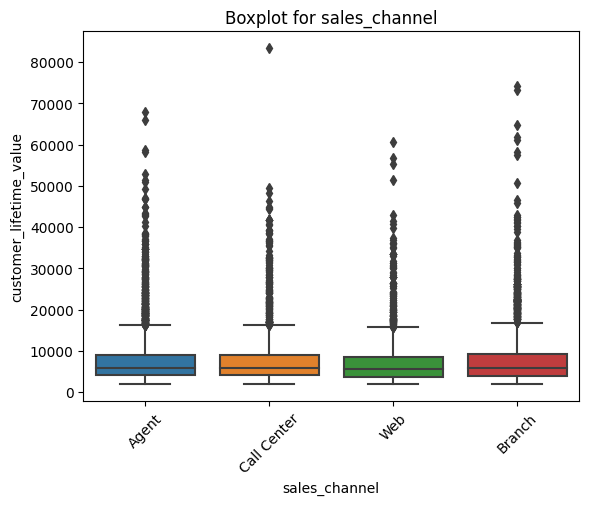

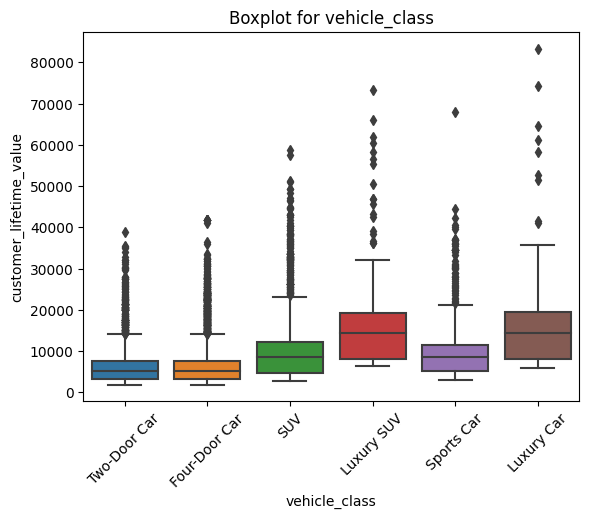

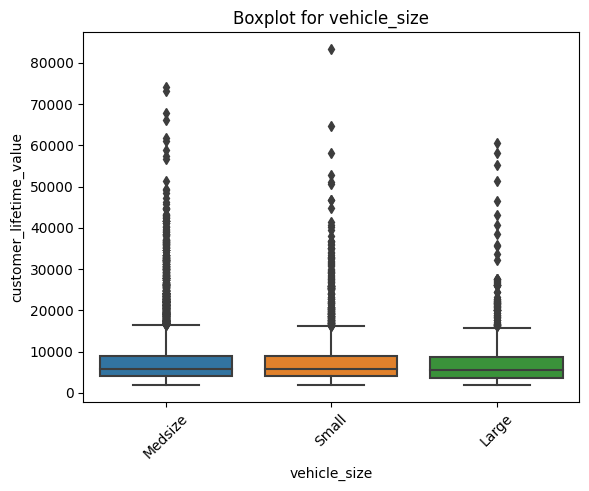

In [6]:
for col in categorical_df.columns:
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.ylabel('customer_lifetime_value')
    plt.xticks(rotation = 45)
    sns.boxplot(x=col, y='customer_lifetime_value', data = customer_df)
    plt.show()

- as with assessing monetary values we expect outliers,
- Interesting that a lot of the outliers in response are of customers with high lifetime value, this could be focused on as a business case.
- We have slightly more outliers with employed over the other statuses of employment which makes sense with poeple earning money leading to increased value,
- Male outliers slightly tend to hold more value then female, as is the same with married and single.



#### Cleaning the Categorical columns

In [7]:
for col in categorical_df.columns:
    print(categorical_df[col].value_counts(), "\n")

state
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: count, dtype: int64 

response
No     7826
Yes    1308
Name: count, dtype: int64 

coverage
Basic       5568
Extended    2742
Premium      824
Name: count, dtype: int64 

education
Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: count, dtype: int64 

employment_status
Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: count, dtype: int64 

gender
F    4658
M    4476
Name: count, dtype: int64 

location_code
Suburban    5779
Rural       1773
Urban       1582
Name: count, dtype: int64 

marital_status
Married     5298
Single      2467
Divorced    1369
Name: count, dtype: int64 

policy_type
Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: count, dtype: int64 

policy
Personal L3     3426
Pers

In [8]:
# The policy column could be bucketed into Personal, Corporate and Special.
policy_count = pd.Series(customer_df['policy'].value_counts(), name = 'counts')
policy_count

policy
Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: counts, dtype: int64

In [9]:
def bucket_policy(x):
    x =str(x).lower()
    if x.startswith('personal'):
        return 'Personal'
    elif x.startswith('corporate'):
        return 'Corporate'
    elif x.startswith('special'):
        return 'Special'
    else:
        return x
    
customer_df['policy'] = customer_df['policy'].apply(bucket_policy)
    
    

In [10]:
customer_df['policy'].value_counts()

policy
Personal     6788
Corporate    1968
Special       378
Name: count, dtype: int64

# Feature Extraction

In [11]:
categorical_df.head()

,state,response,coverage,education,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
customer_id,,,,,,,,,,,,,,
BU79786,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
QZ44356,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
AI49188,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
WW63253,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
HB64268,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


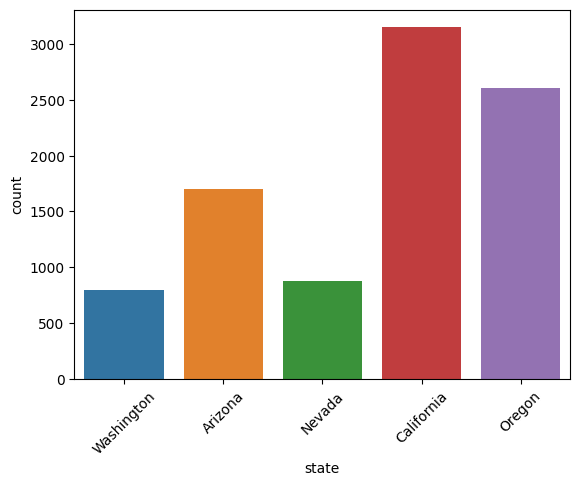

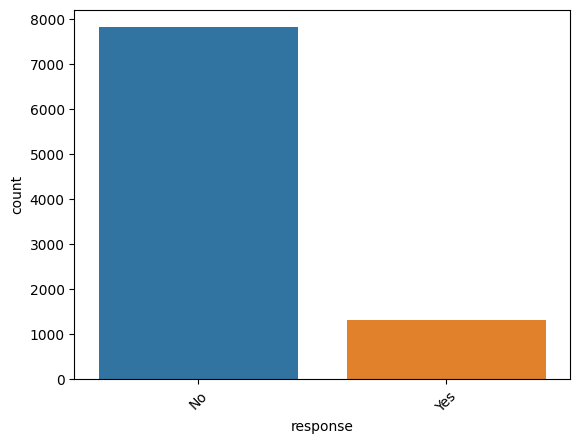

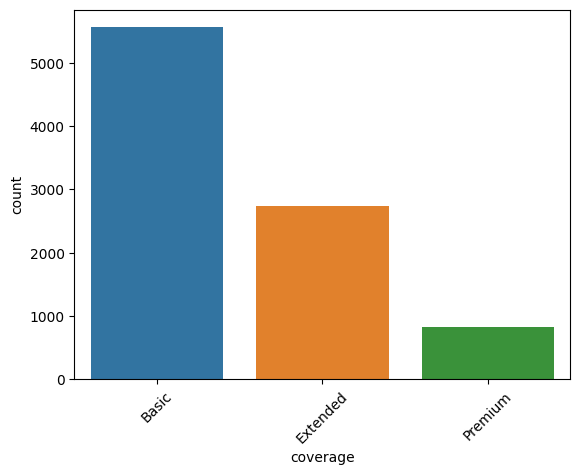

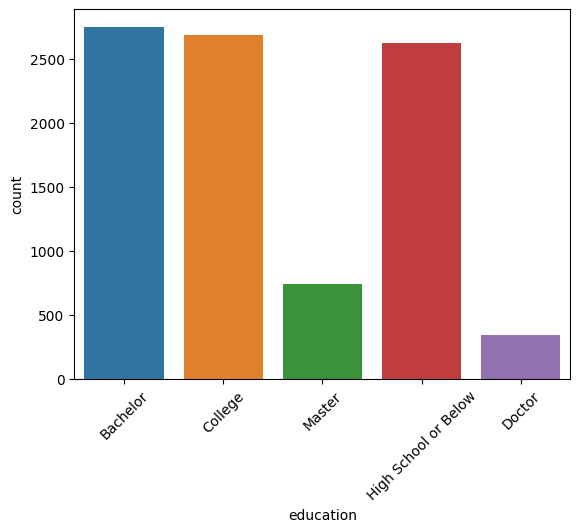

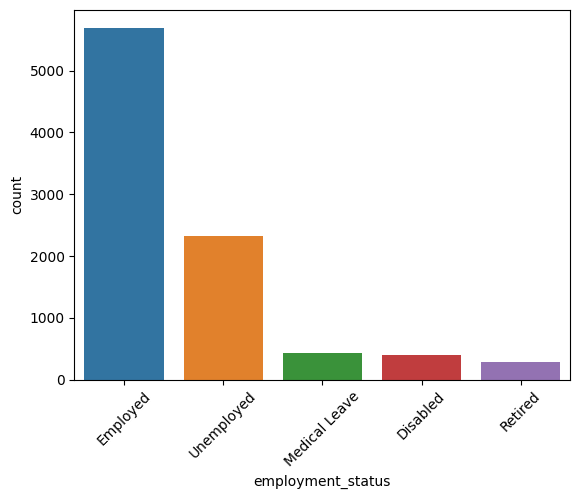

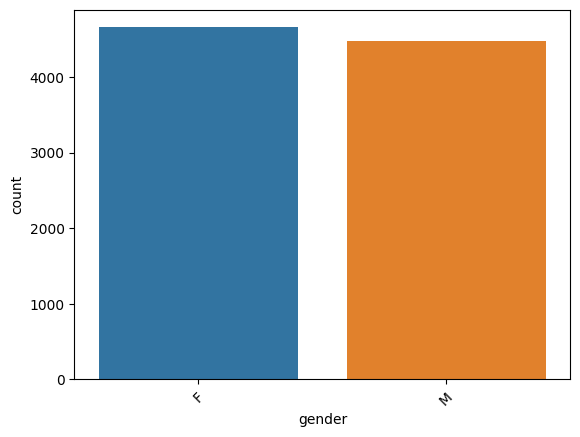

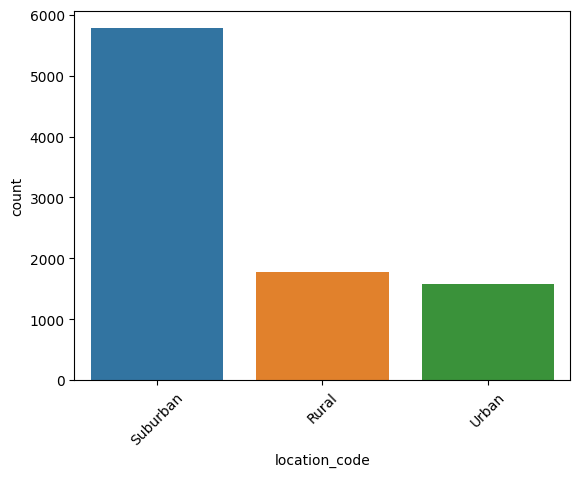

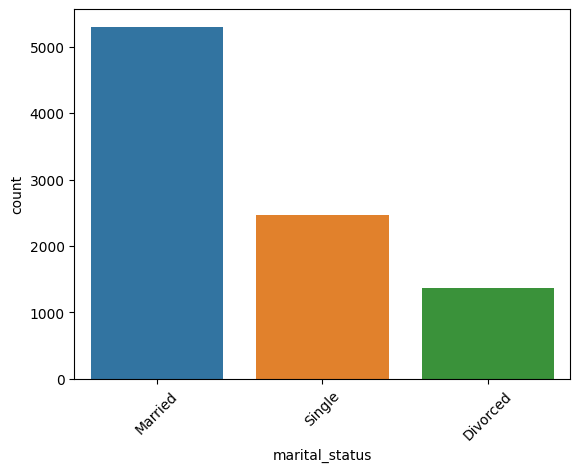

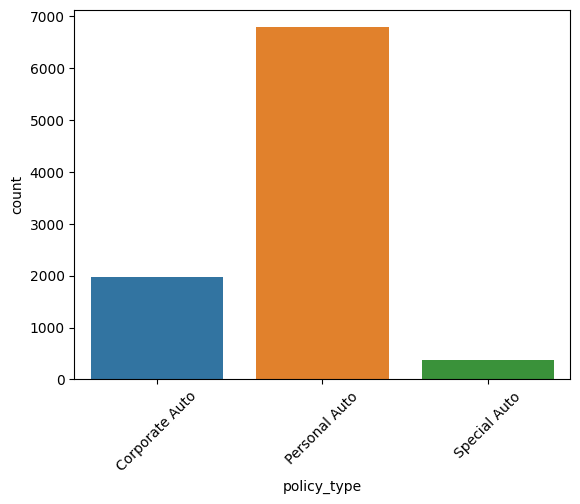

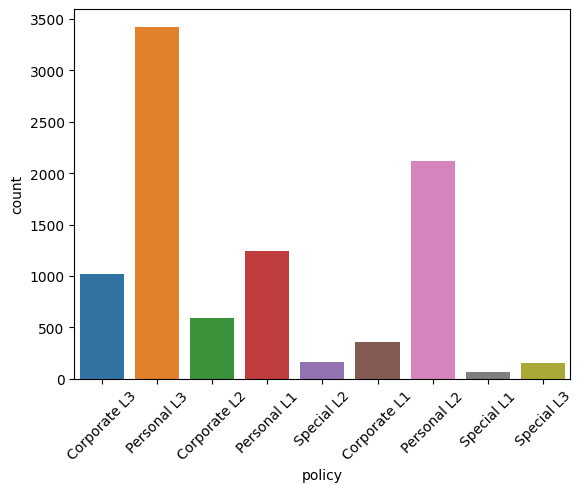

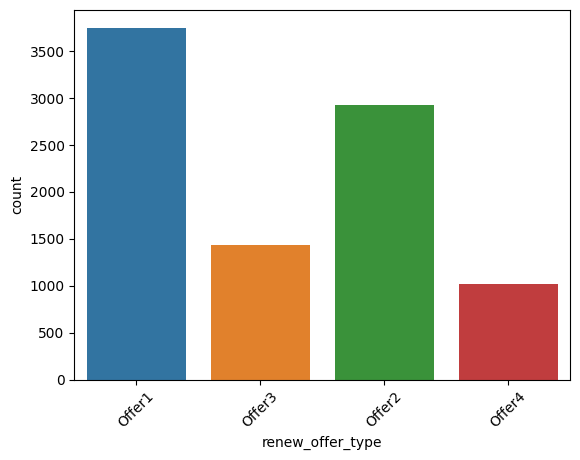

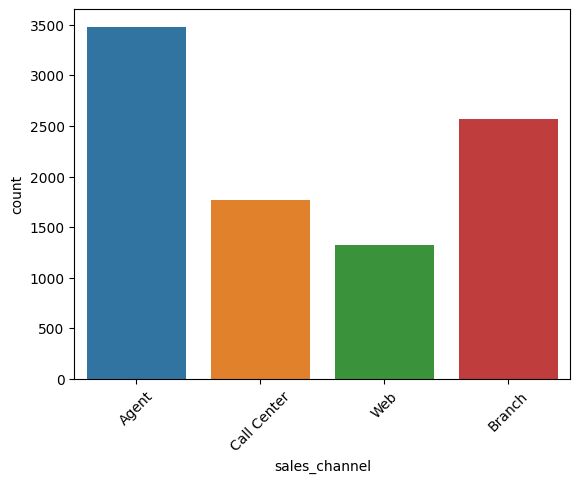

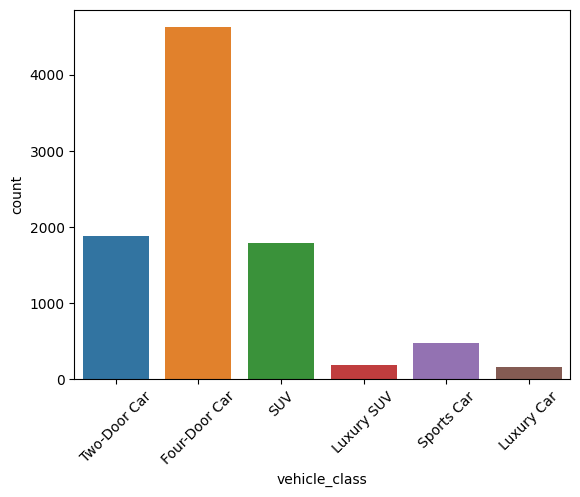

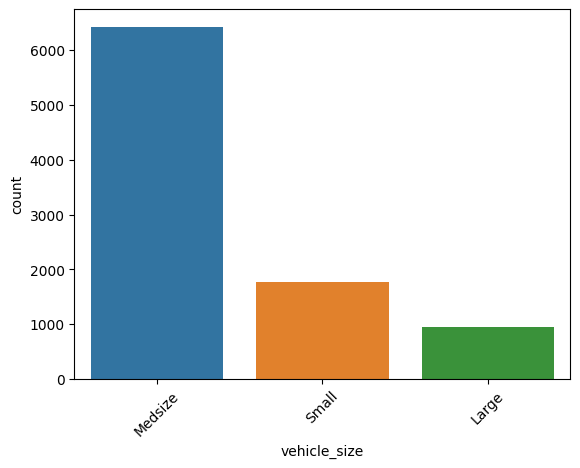

In [12]:
for col in categorical_df.columns:
    sns.countplot(x=categorical_df[col])
    plt.xticks(rotation = 45)
    plt.show()

## Insights from count plots.
- Customer info columns such as State, education, employment_status, gender, location_code and martial_status all seem to show unique data that usually should not correlate with each other.
- the policy_type and policy columns will likely be very similar so could maybe be extracted or engineered to suit the model better as is the same with vehicle_class and vehicle_size.

## Checking value counts of categorical columns.

In [13]:
for col in categorical_df.columns:
    print(categorical_df[col].value_counts(), "\n")

state
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: count, dtype: int64 

response
No     7826
Yes    1308
Name: count, dtype: int64 

coverage
Basic       5568
Extended    2742
Premium      824
Name: count, dtype: int64 

education
Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: count, dtype: int64 

employment_status
Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: count, dtype: int64 

gender
F    4658
M    4476
Name: count, dtype: int64 

location_code
Suburban    5779
Rural       1773
Urban       1582
Name: count, dtype: int64 

marital_status
Married     5298
Single      2467
Divorced    1369
Name: count, dtype: int64 

policy_type
Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: count, dtype: int64 

policy
Personal L3     3426
Pers

- As we seen with our countplots policy_type and policy they contain the same info and either one could be dropped but keeping the policy might be more useful as it contains more info on the type of policy.
- The same is true for vehicle_class and vehicle_size where i think keeping vehicle_class would be more useful.
- But we can check further with Chi-Square Test ,p_value or VIF.

In [14]:
customer_df = customer_df.drop(['policy_type'], axis = 1)
customer_df = customer_df.drop(['vehicle_size'], axis = 1)
customer_df.head()

,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class
customer_id,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate,Offer1,Agent,384.811147,Two-Door Car
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal,Offer3,Agent,1131.464935,Four-Door Car
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal,Offer1,Agent,566.472247,Two-Door Car
WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate,Offer1,Call Center,529.881344,SUV
HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal,Offer1,Agent,138.130879,Four-Door Car


## Plotting the time variable using Lineplot.

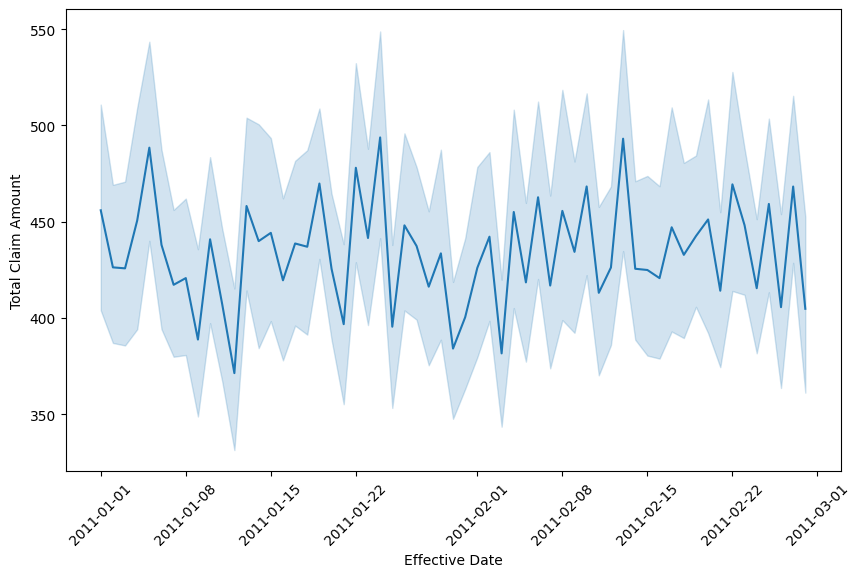

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='effective_to_date', y='total_claim_amount', data=customer_df)
plt.xlabel('Effective Date')
plt.ylabel('Total Claim Amount')
plt.xticks(rotation = 45)
plt.show()

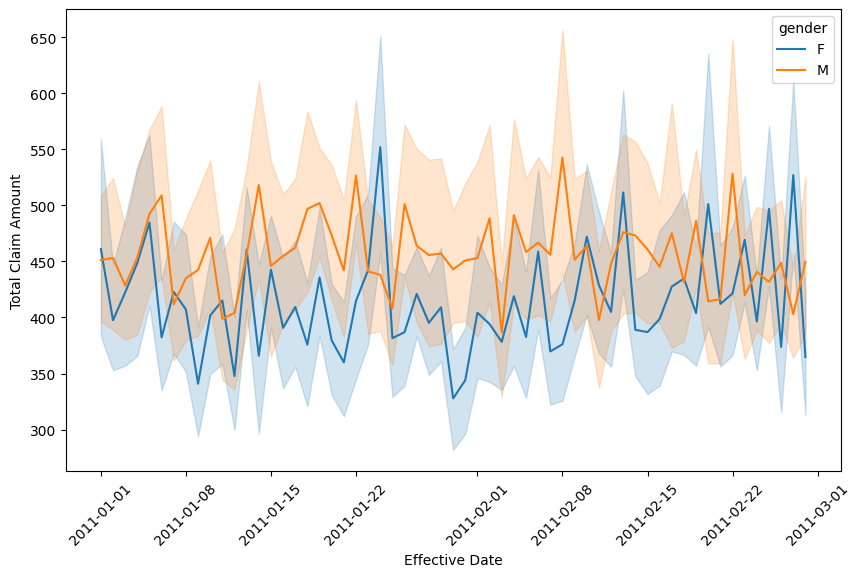

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='effective_to_date', y='total_claim_amount',hue='gender', data=customer_df)
plt.xlabel('Effective Date')
plt.ylabel('Total Claim Amount')
plt.xticks(rotation = 45)
plt.show()

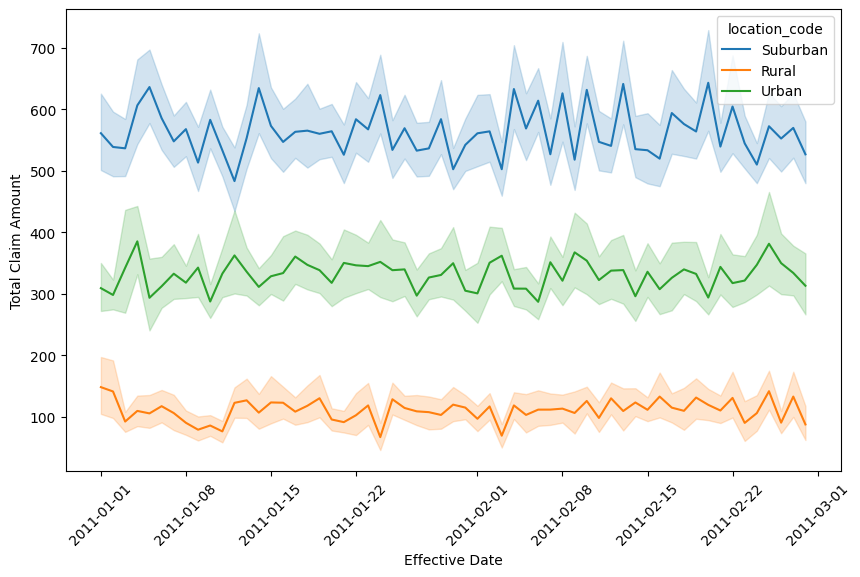

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='effective_to_date', y='total_claim_amount', hue = 'location_code', data=customer_df)
plt.xlabel('Effective Date')
plt.ylabel('Total Claim Amount')
plt.xticks(rotation = 45)
plt.show()

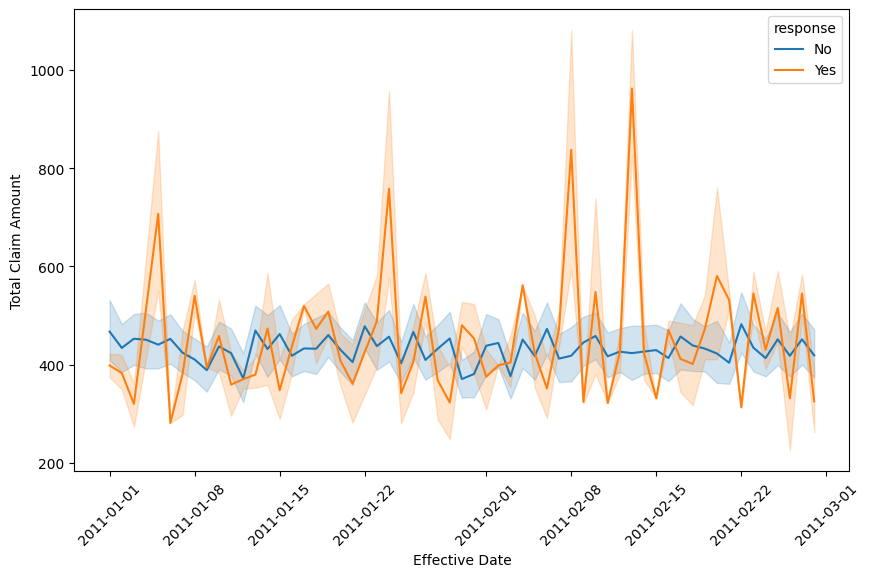

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='effective_to_date', y='total_claim_amount',hue = 'response', data=customer_df)
plt.xlabel('Effective Date')
plt.ylabel('Total Claim Amount')
plt.xticks(rotation = 45)
plt.show()

- Not really sure what to extract from the first graph but from the others we see some interesting points.
- Males for the majority of time have a higher total claim amount up until 2011.02.08 where females start to rise.
- We see class differences over time with location code, with suburban being the highest claimers.
- interesting to see a lot of the yes's come from periods of high claim amounts.

## Data Cleaning and Wrangling.

#### Removing outliers:


In [19]:
summary = customer_df.describe().T
summary

,count,mean,min,25%,50%,75%,max,std
customer_lifetime_value,9134.0,8004.940475,1898.007675,3994.251794,5780.182197,8962.167041,83325.38119,6870.967608
effective_to_date,9134,2011-01-29 20:06:21.519597056,2011-01-01 00:00:00,2011-01-15 00:00:00,2011-01-29 00:00:00,2011-02-13 00:00:00,2011-02-28 00:00:00,NaN
income,9134.0,37657.380009,0.0,0.0,33889.5,62320.0,99981.0,30379.904734
monthly_premium_auto,9134.0,93.219291,61.0,68.0,83.0,109.0,298.0,34.407967
months_since_last_claim,9134.0,15.097,0.0,6.0,14.0,23.0,35.0,10.073257
months_since_policy_inception,9134.0,48.064594,0.0,24.0,48.0,71.0,99.0,27.905991
number_of_open_complaints,9134.0,0.384388,0.0,0.0,0.0,0.0,5.0,0.910384
number_of_policies,9134.0,2.96617,1.0,1.0,2.0,4.0,9.0,2.390182
total_claim_amount,9134.0,434.088794,0.099007,272.258244,383.945434,547.514839,2893.239678,290.500092


In [20]:
summary['iqr'] = summary['75%'] - summary['25%']
summary = summary.round(2)
summary

,count,mean,min,25%,50%,75%,max,std,iqr
customer_lifetime_value,9134.0,8004.940475,1898.007675,3994.251794,5780.182197,8962.167041,83325.38119,6870.967608,4967.915247
effective_to_date,9134,2011-01-29 20:06:21.519597056,2011-01-01 00:00:00,2011-01-15 00:00:00,2011-01-29 00:00:00,2011-02-13 00:00:00,2011-02-28 00:00:00,NaN,29 days 00:00:00
income,9134.0,37657.380009,0.0,0.0,33889.5,62320.0,99981.0,30379.904734,62320.0
monthly_premium_auto,9134.0,93.219291,61.0,68.0,83.0,109.0,298.0,34.407967,41.0
months_since_last_claim,9134.0,15.097,0.0,6.0,14.0,23.0,35.0,10.073257,17.0
months_since_policy_inception,9134.0,48.064594,0.0,24.0,48.0,71.0,99.0,27.905991,47.0
number_of_open_complaints,9134.0,0.384388,0.0,0.0,0.0,0.0,5.0,0.910384,0.0
number_of_policies,9134.0,2.96617,1.0,1.0,2.0,4.0,9.0,2.390182,3.0
total_claim_amount,9134.0,434.088794,0.099007,272.258244,383.945434,547.514839,2893.239678,290.500092,275.256594


### Removing outliers by using iqr inside a function.

In [21]:
def remove_outliers(df, threshold=1.5):
    for col in numerical_df:
        q1 = customer_df[col].quantile(0.25)
        q3 = customer_df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

customer_no_outliers = remove_outliers(customer_df)

In [22]:
customer_no_outliers

,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class
customer_id,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate,Offer1,Agent,384.811147,Two-Door Car
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal,Offer1,Agent,566.472247,Two-Door Car
WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate,Offer1,Call Center,529.881344,SUV
HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal,Offer1,Agent,138.130879,Four-Door Car
OC83172,Oregon,8256.297800,Yes,Basic,Bachelor,2011-01-25,Employed,F,62902,Rural,Married,69,14,94,0,2,Personal,Offer2,Web,159.383042,Two-Door Car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF56202,California,5032.165498,No,Basic,College,2011-02-12,Employed,M,66367,Suburban,Divorced,64,6,48,0,3,Personal,Offer2,Call Center,307.200000,Two-Door Car
YM19146,California,4100.398533,No,Premium,College,2011-01-06,Employed,F,47761,Suburban,Single,104,16,58,0,1,Personal,Offer1,Branch,541.282007,Four-Door Car
PK87824,California,3096.511217,Yes,Extended,College,2011-02-12,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate,Offer1,Branch,379.200000,Four-Door Car


In [23]:
customer_no_out = customer_no_outliers.copy()

 ### Scaling the features using Standard Scaler.

In [24]:
num_no_out = customer_no_outliers.select_dtypes(include = 'number').columns
cat_no_out = customer_no_outliers.select_dtypes('object').columns

In [25]:
#scaler = StandardScaler()
#customer_no_out[num_no_out] = scaler.fit_transform(customer_no_out[num_no_out]) 


In [26]:
customer_no_out

,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class
customer_id,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate,Offer1,Agent,384.811147,Two-Door Car
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal,Offer1,Agent,566.472247,Two-Door Car
WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate,Offer1,Call Center,529.881344,SUV
HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal,Offer1,Agent,138.130879,Four-Door Car
OC83172,Oregon,8256.297800,Yes,Basic,Bachelor,2011-01-25,Employed,F,62902,Rural,Married,69,14,94,0,2,Personal,Offer2,Web,159.383042,Two-Door Car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF56202,California,5032.165498,No,Basic,College,2011-02-12,Employed,M,66367,Suburban,Divorced,64,6,48,0,3,Personal,Offer2,Call Center,307.200000,Two-Door Car
YM19146,California,4100.398533,No,Premium,College,2011-01-06,Employed,F,47761,Suburban,Single,104,16,58,0,1,Personal,Offer1,Branch,541.282007,Four-Door Car
PK87824,California,3096.511217,Yes,Extended,College,2011-02-12,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate,Offer1,Branch,379.200000,Four-Door Car


### Encoding the categorical variables.

In [27]:
## I originally tried OneHotEncoder but couldnt get it to work will study more to fix.
dummie_cols = ['state', 'marital_status', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class']
customer_no_en = pd.get_dummies(customer_no_out, columns=dummie_cols, drop_first=True)
customer_no_en

,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,state_California,state_Nevada,state_Oregon,state_Washington,marital_status_Married,marital_status_Single,policy_Personal,policy_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,69,32,5,0,1,384.811147,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True
AI49188,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,108,18,38,0,2,566.472247,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True
WW63253,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,106,18,65,0,7,529.881344,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
HB64268,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,73,12,44,0,1,138.130879,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False
OC83172,8256.297800,Yes,Basic,Bachelor,2011-01-25,Employed,F,62902,Rural,69,14,94,0,2,159.383042,False,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF56202,5032.165498,No,Basic,College,2011-02-12,Employed,M,66367,Suburban,64,6,48,0,3,307.200000,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True
YM19146,4100.398533,No,Premium,College,2011-01-06,Employed,F,47761,Suburban,104,16,58,0,1,541.282007,True,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False
PK87824,3096.511217,Yes,Extended,College,2011-02-12,Employed,F,21604,Suburban,79,14,28,0,1,379.200000,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


#### Ordinal encoding coverage, employment_status, location_code and I have dropped vehicle_size when cleaning the categorical columns

In [28]:
customer_no_en["coverage"] = customer_no_en["coverage"].map({"Basic" : 0, "Extended" : 1, "Premium" : 2})
customer_no_en['employment_status'] = customer_no_en['employment_status'].map({'Retired' : 0, 'Disabled' : 1,
                                                                               'Medical Leave' : 2, 'Unemployed' : 3,
                                                                             'Employed' : 4})
customer_no_en['location_code'] = customer_no_en['location_code'].map({'Rural' : 0, 'Urban' : 1, 'Suburban' : 2})




In [29]:
customer_no_en

,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,state_California,state_Nevada,state_Oregon,state_Washington,marital_status_Married,marital_status_Single,policy_Personal,policy_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,2763.519279,No,0,Bachelor,2011-02-24,4,F,56274,2,69,32,5,0,1,384.811147,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True
AI49188,12887.431650,No,2,Bachelor,2011-02-19,4,F,48767,2,108,18,38,0,2,566.472247,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True
WW63253,7645.861827,No,0,Bachelor,2011-01-20,3,M,0,2,106,18,65,0,7,529.881344,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
HB64268,2813.692575,No,0,Bachelor,2011-02-03,4,M,43836,0,73,12,44,0,1,138.130879,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False
OC83172,8256.297800,Yes,0,Bachelor,2011-01-25,4,F,62902,0,69,14,94,0,2,159.383042,False,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF56202,5032.165498,No,0,College,2011-02-12,4,M,66367,2,64,6,48,0,3,307.200000,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True
YM19146,4100.398533,No,2,College,2011-01-06,4,F,47761,2,104,16,58,0,1,541.282007,True,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False
PK87824,3096.511217,Yes,1,College,2011-02-12,4,F,21604,2,79,14,28,0,1,379.200000,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


#### Changing effective_to_date into day, week and month and as integers.

In [30]:
customer_no_en['day'] = customer_no_en['effective_to_date'].dt.day.astype(int)
customer_no_en['week'] = customer_no_en['effective_to_date'].dt.isocalendar().week.astype(int)
customer_no_en['month'] = customer_no_en['effective_to_date'].dt.month.astype(int)
customer_no_en = customer_no_en.drop('effective_to_date', axis=1)


checking and changing all columns into numerical

In [31]:
customer_no_en.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, BU79786 to Y167826
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_lifetime_value        5911 non-null   float64
 1   response                       5911 non-null   object 
 2   coverage                       5911 non-null   int64  
 3   education                      5911 non-null   object 
 4   employment_status              5911 non-null   int64  
 5   gender                         5911 non-null   object 
 6   income                         5911 non-null   int64  
 7   location_code                  5911 non-null   int64  
 8   monthly_premium_auto           5911 non-null   int64  
 9   months_since_last_claim        5911 non-null   int64  
 10  months_since_policy_inception  5911 non-null   int64  
 11  number_of_open_complaints      5911 non-null   int64  
 12  number_of_policies             5911 non-null

In [32]:
dummie_col = ['response', 'education', 'gender']
customer_no_en = pd.get_dummies(customer_no_en, columns=dummie_col, drop_first=True)


Scaling the intgers we got from converting columns to numericals.

In [33]:
num_no_en = customer_no_en.select_dtypes(include = 'number').columns
scaler = StandardScaler()
customer_no_en[num_no_en] = scaler.fit_transform(customer_no_en[num_no_en]) 
customer_no_en

,customer_lifetime_value,coverage,employment_status,income,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,state_California,state_Nevada,state_Oregon,state_Washington,marital_status_Married,marital_status_Single,policy_Personal,policy_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,day,week,month,response_Yes,education_College,education_Doctor,education_High School or Below,education_Master,gender_M
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,-1.048979,-0.714162,0.605531,0.583364,0.727012,-0.785870,1.709316,-1.547090,0.0,-0.817698,-0.005838,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,0.994917,0.216980,1.069942,False,False,False,False,False,False
AI49188,2.139579,2.459831,0.605531,0.336541,0.727012,0.978915,0.306961,-0.369012,0.0,-0.342343,0.870355,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,0.417288,0.102536,1.069942,False,False,False,False,False,False
WW63253,0.488730,-0.714162,-0.399042,-1.266871,0.727012,0.888413,0.306961,0.594870,0.0,2.034434,0.693868,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,0.532814,-0.355237,-0.934630,False,False,False,False,False,True
HB64268,-1.033177,-0.714162,0.605531,0.174414,-1.770733,-0.604866,-0.294048,-0.154816,0.0,-0.817698,-1.195633,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,-1.431124,-0.126350,1.069942,False,False,False,False,False,True
OC83172,0.680989,-0.714162,0.605531,0.801286,-1.770733,-0.785870,-0.093712,1.630151,0.0,-0.342343,-1.093129,False,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,True,1.110443,-0.240794,-0.934630,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF56202,-0.334462,-0.714162,0.605531,0.915212,0.727012,-1.012124,-0.895057,-0.012019,0.0,0.133013,-0.380174,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,-0.391392,-0.011907,1.069942,False,True,False,False,False,True
YM19146,-0.627925,2.459831,0.605531,0.303465,0.727012,0.797912,0.106625,0.344975,0.0,-0.817698,0.748856,True,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,-1.084547,-0.584124,-0.934630,False,True,False,False,False,False
PK87824,-0.944103,0.872835,0.605531,-0.556552,0.727012,-0.333361,-0.093712,-0.726005,0.0,-0.817698,-0.032902,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,-0.391392,-0.011907,1.069942,True,True,False,False,False,False


In [34]:
X = customer_no_en.drop('total_claim_amount', axis=1)
y = customer_no_en['total_claim_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

lr = LinearRegression()
lr.fit(X_train, y_train)
print("R2:", lr.score(X_test, y_test))
print("MAE:", mean_absolute_error(lr.predict(X_test), y_test))
print("RMSE:", mean_squared_error(lr.predict(X_test), y_test, squared=False))

R2: 0.7726729389361284
MAE: 0.37006459848637424
RMSE: 0.4682753098489536


### Making a function to check LinearRegression , KNeighborsRegressor and MLPRegressor

In [40]:
reg_models = [LinearRegression(), KNeighborsRegressor(), MLPRegressor()]

def regression_model(models, data):
    X = data.drop('total_claim_amount', axis=1)
    y = data['total_claim_amount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score = model.score(X_test, y_test)
        rmse = mean_squared_error(y_test, pred, squared=False)
        mae = mean_absolute_error(y_test, pred)
        print("Model:", model.__class__.__name__)
        print("R2_score:", score)
        print("RMSE:", rmse)
        print("MAE:", mae)
        print()
    
regression_model(reg_models, customer_no_en)

Model: LinearRegression
R2_score: 0.7726729389361284
RMSE: 0.4682753098489536
MAE: 0.37006459848637424

Model: KNeighborsRegressor
R2_score: 0.7303628351063818
RMSE: 0.5099945878169394
MAE: 0.36236181320526545

Model: MLPRegressor
R2_score: 0.7710836412312659
RMSE: 0.46990937098655494
MAE: 0.3516246948275267



## Results

- The Linear Regression model gave the best R2 score of 0.772 which is marginally better than MLPRegressor, while KNeighboursRegressor gave the lowest at R2 = 0.73.
- Between the RMSE and MAE, MLPRegressor performed the best of the models. which overall might be the best model for our dataset.